# Going on a Random Walk

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## GOOGL - April 28, 2020 to April 27, 2021

In [4]:
url1 = ('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/GOOGL.csv')
df = pd.read_csv(url1)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


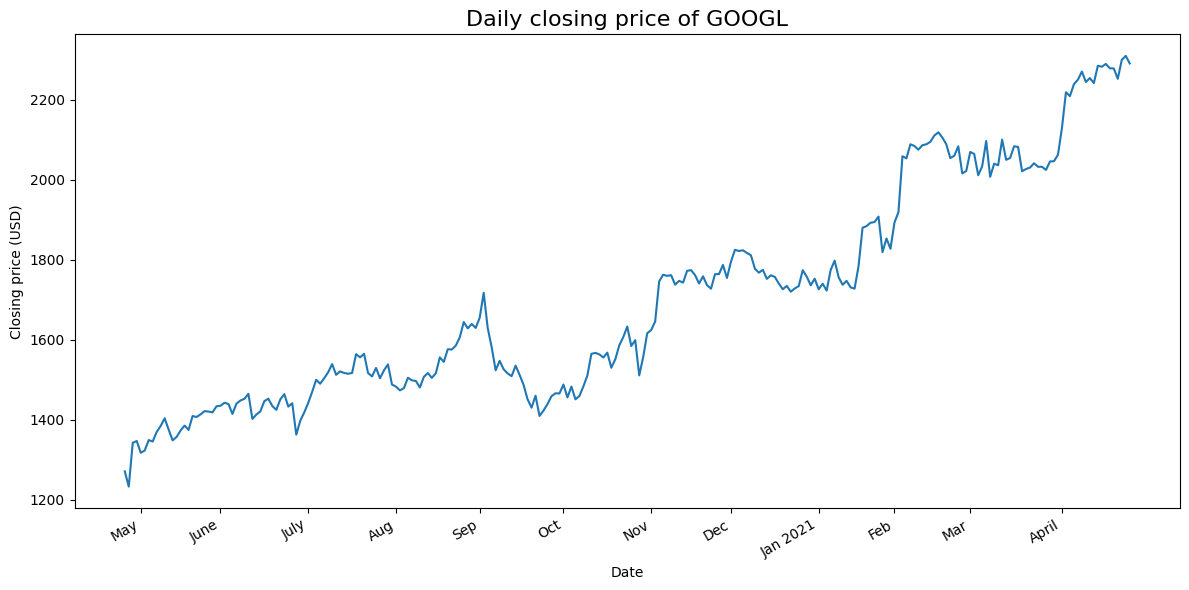

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
ax.set_title('Daily closing price of GOOGL', fontsize=16)

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235], 
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2021', 'Feb', 'Mar', 'April'])

fig.autofmt_xdate()
plt.tight_layout()

#plt.savefig('figures/CH03_F01_peixeiro.png', dpi=300)

## 3.1 The Random Walk process 

In [9]:
steps = np.random.standard_normal(1000)  # Generate 1000 random numbers from a standard normal distribution (mean=0, std=1)
steps[0] = 0                             # Set the first step to 0, ensuring the random walk starts at 0

random_walk = np.cumsum(steps)           # Calculate the cumulative sum of the steps to simulate the random walk

random_walk[:10]                         # First 10 values

array([ 0.        , -0.25039692,  0.29514221,  0.6769105 ,  1.63369655,
        1.57944134,  1.95597661,  0.82419455,  0.26505165,  0.40298276])

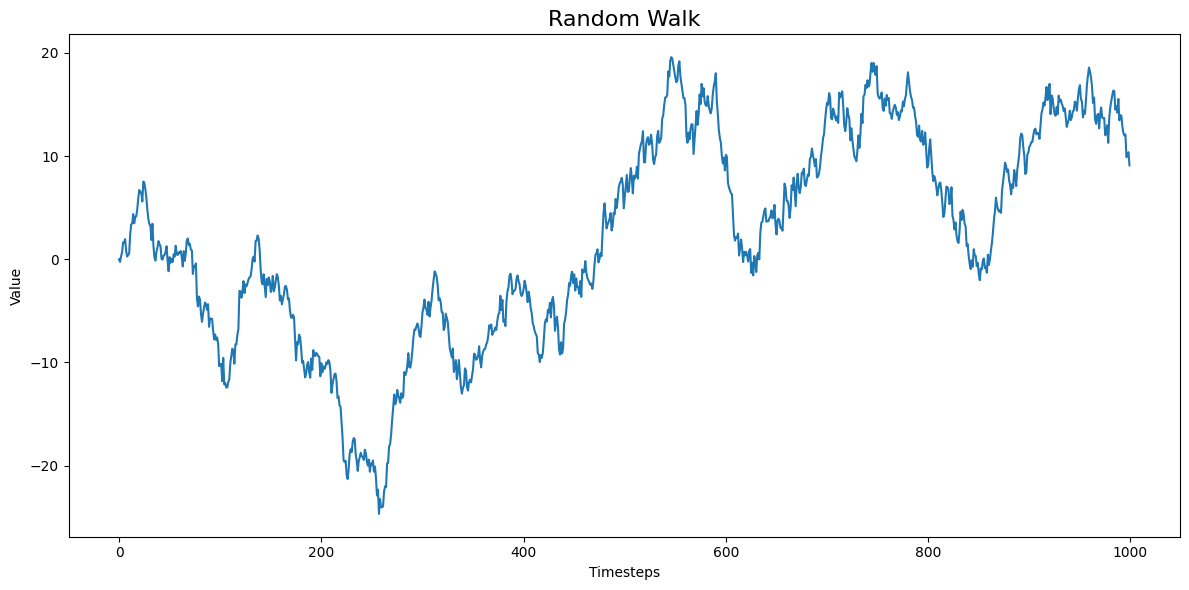

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Random Walk', fontsize=16)

plt.tight_layout()

### 3.2.2 Testing for stationarity 

The examples are:

$$
y_t = 0.5 y_{t-1} + \epsilon_t \quad \text{(stationary)}
$$

$$
y_t = y_{t-1} + \epsilon_t \quad \text{(not stationary)}
$$


In [15]:
# A bizzarre way to express these two equations:

def simulate_process(is_stationary: bool) -> np.array:
    np.random.seed(42)
    process = np.empty(400)
    
    if is_stationary:
        alpha = 0.5
        process[0] = 0
    else:
        alpha = 1
        process[0] = 10
        
    for i in range(400):
        if i+1 < 400:
            process[i+1] = alpha*process[i] + np.random.standard_normal()
        else:
            break
        
    return process

In [17]:
stationary = simulate_process(True)
non_stationary = simulate_process(False)

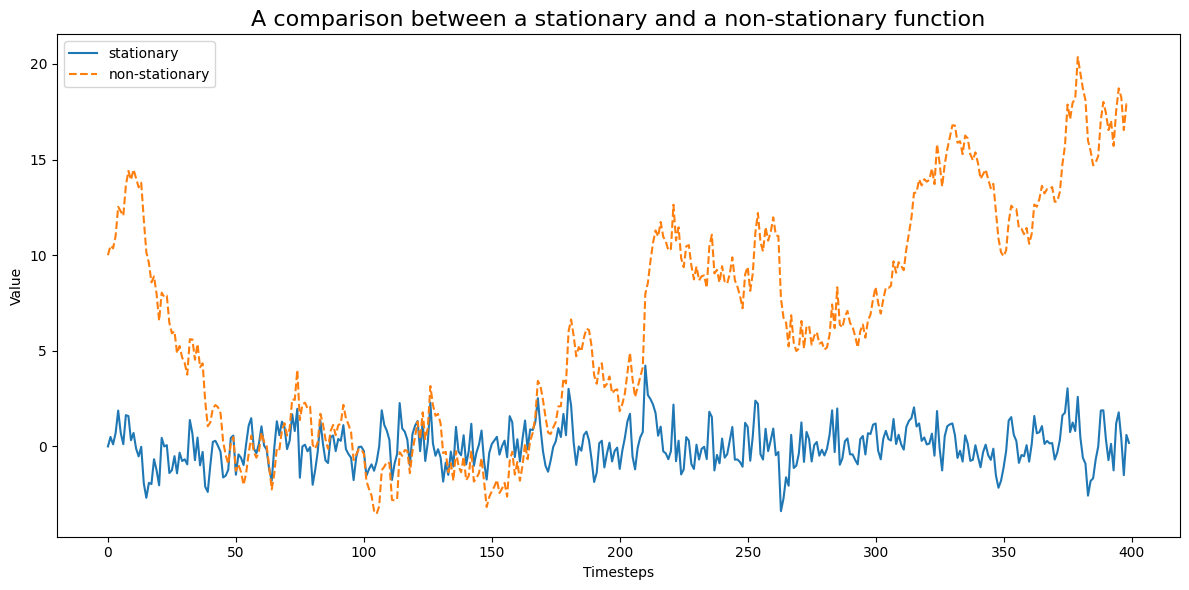

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(stationary, linestyle='-', label='stationary')
ax.plot(non_stationary, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc=2)
ax.set_title('A comparison between a stationary and a non-stationary function', fontsize=16)

plt.tight_layout()

In [20]:
# Define the function mean_over_time that takes a numpy array as input
def mean_over_time(process: np.array) -> np.array:  
    mean_func = []                              # Initialize an empty list to store the mean values
    
    for i in range(len(process)):               # Iterate over each element in the input array
        mean_func.append(np.mean(process[:i]))  # Append the mean of the slice of the array from the start to the current index
    
    return mean_func                            # Return the list containing the calculated means


In [23]:
stationary_mean = mean_over_time(stationary)
non_stationary_mean = mean_over_time(non_stationary)

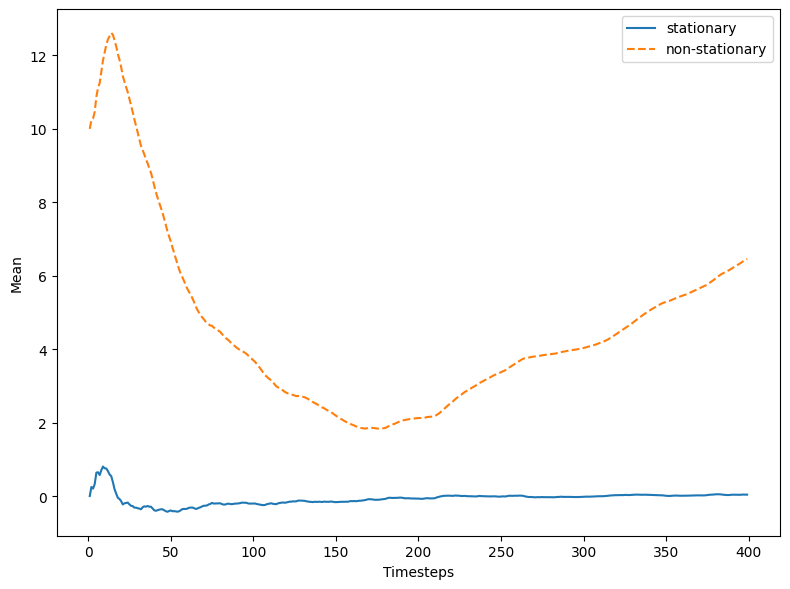

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(stationary_mean, label='stationary')
ax.plot(non_stationary_mean, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean')
ax.legend(loc=1)

plt.tight_layout()

In [27]:
# Define the function var_over_time that takes a numpy array as input
def var_over_time(process: np.array) -> np.array:  
    var_func = []                             # Initialize an empty list to store the variance values
    
    for i in range(len(process)):             # Iterate over each element in the input array
        var_func.append(np.var(process[:i]))  # Append the variance of the slice of the array from the start to the current index
    
    return var_func                           # Return the list containing the calculated variances

In [29]:
stationary_var = var_over_time(stationary)
non_stationary_var = var_over_time(non_stationary)

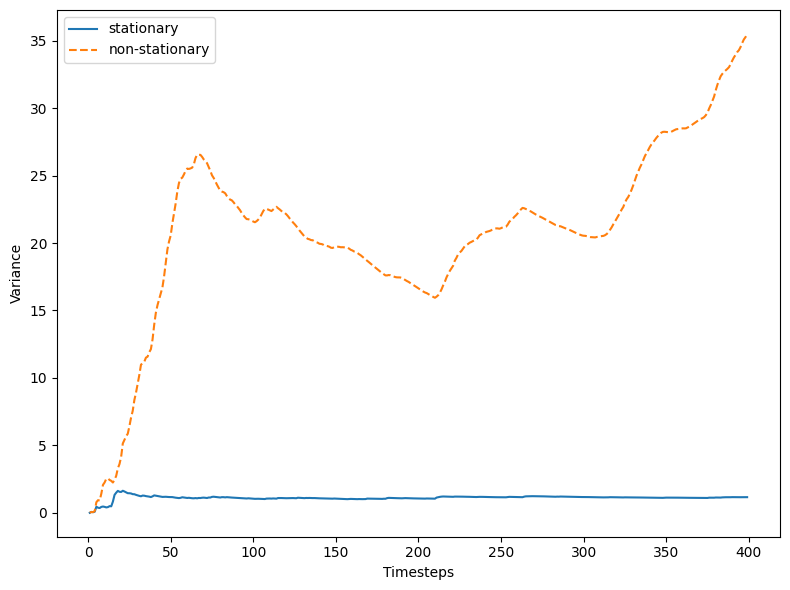

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(stationary_var, label='stationary')
ax.plot(non_stationary_var, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance')
ax.legend(loc=2)

plt.tight_layout()

### 3.2.4 Putting it all together 

#### Augmented Dickey Fuller (ADF)

    H0: Not stationary
    Ha: Stationary

In [35]:
ADF_result = adfuller(random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.4872515696276853
p-value: 0.5398081150197135


This prints an ADF statistic of -2.24 and a p-value of 0.77. With a p-value greater than 0.05, we cannot reject the null
hypothesis stating that our time series is **not stationary**. 

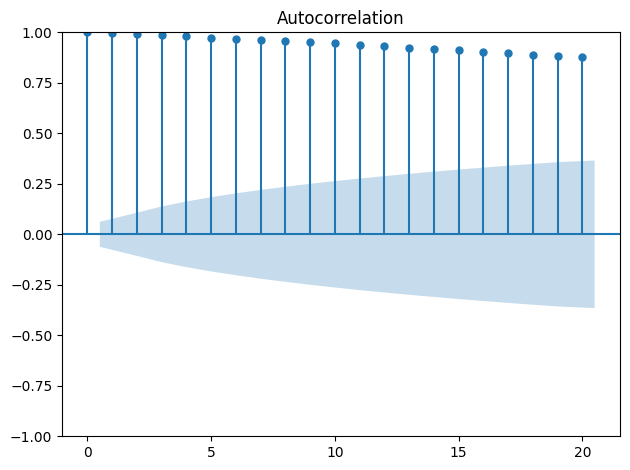

In [38]:
# Auto Correlation Function
plot_acf(random_walk, lags=20);

plt.tight_layout()

The graphic show as each interaction very dependable from the previous point: **not stationary**

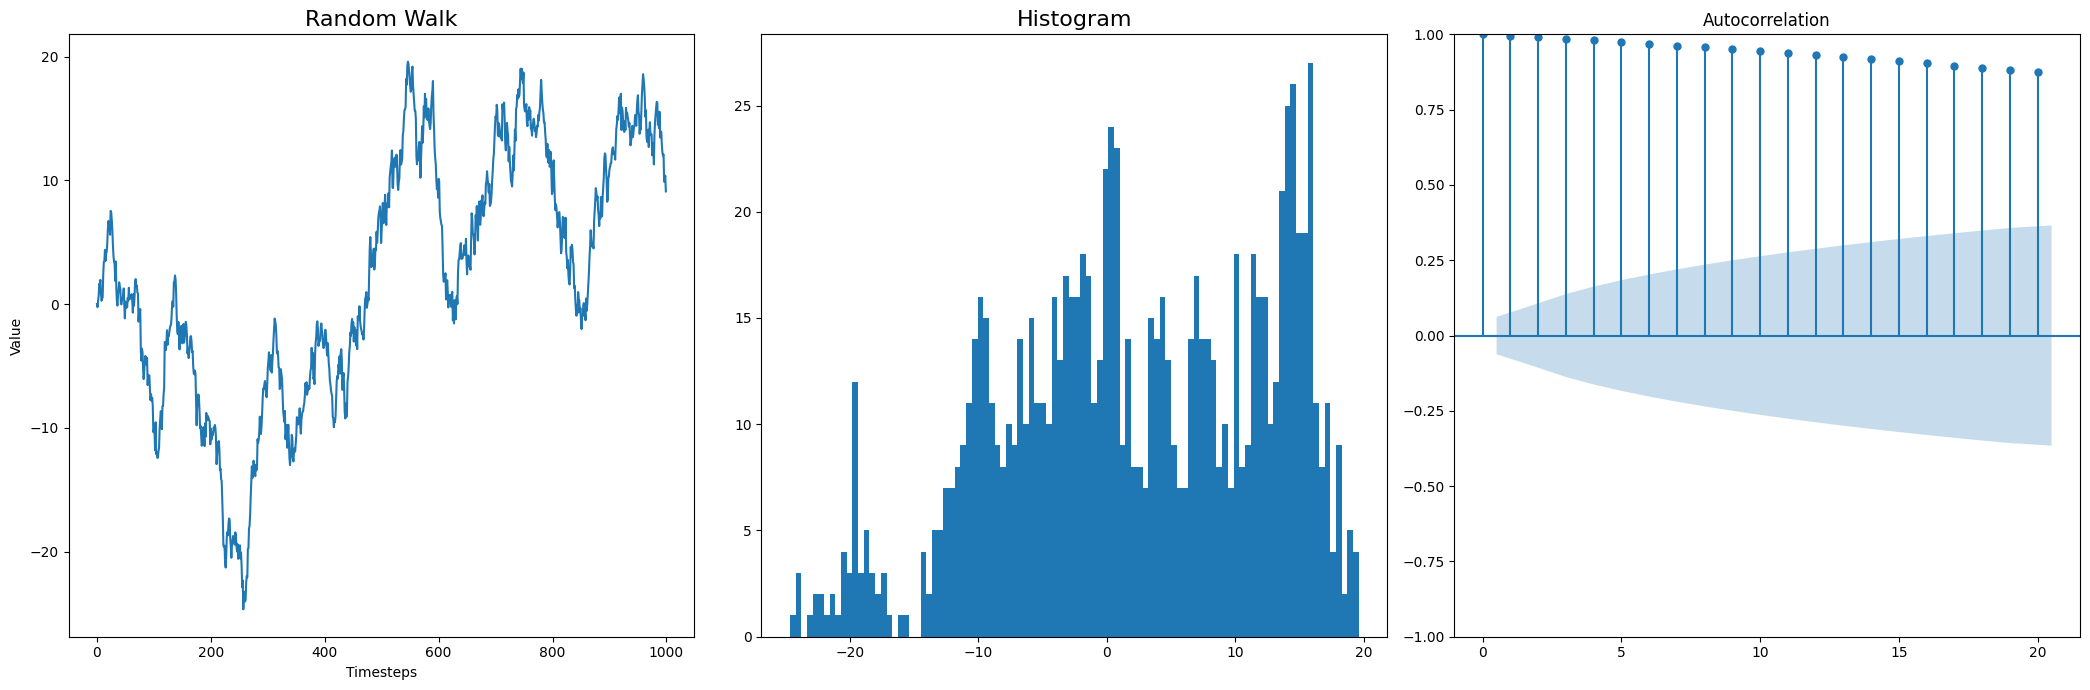

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7)) 

# Subplot 1: Random Walk
ax[0].plot(random_walk) 
ax[0].set_xlabel('Timesteps')
ax[0].set_ylabel('Value')
ax[0].set_title('Random Walk', fontsize=16)

# Subplot 2: Histogram of Random Walk
ax[1].hist(random_walk, bins=100)
ax[1].set_title('Histogram', fontsize=16)

# Subplot 3: Autocorrelation Plot
plot_acf(random_walk, lags=20, ax=ax[2])

plt.tight_layout()
plt.show() 

The histogram, despite using 1000 samples, does not look like as a gaussian distribution. If is not a gaussian distribution it indicates the series is not stationary.

In [44]:
# Detrending
diff_random_walk = np.diff(random_walk, n=1) # First-order differencing

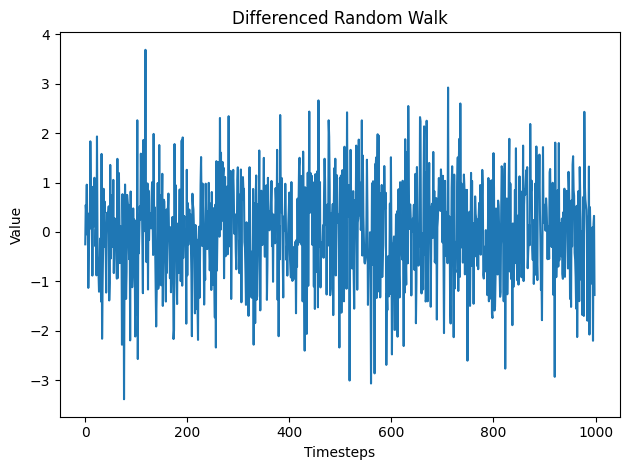

In [46]:
plt.plot(diff_random_walk)
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()

In [48]:
# Augmented Dickey Fuller's test for 'diff_random_walk' 
ADF_result = adfuller(diff_random_walk)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -32.45985847103307
p-value: 0.0


The Augmented Dickey Fuller's test said to us:

    p-value (0.0) < alpha (0.05); Ha: the first-order difference is stationary!

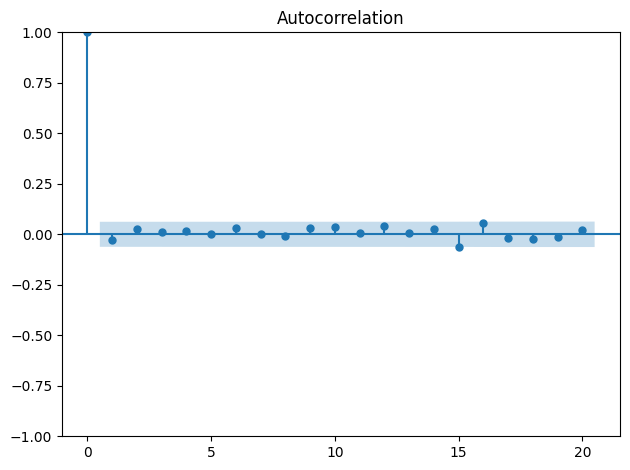

In [51]:
# Plot Auto Correlation Function
plot_acf(diff_random_walk, lags=20);

plt.tight_layout()

Now, after applying the first-order difference, the series appears stationary. We can confirm this by looking at the histogram.

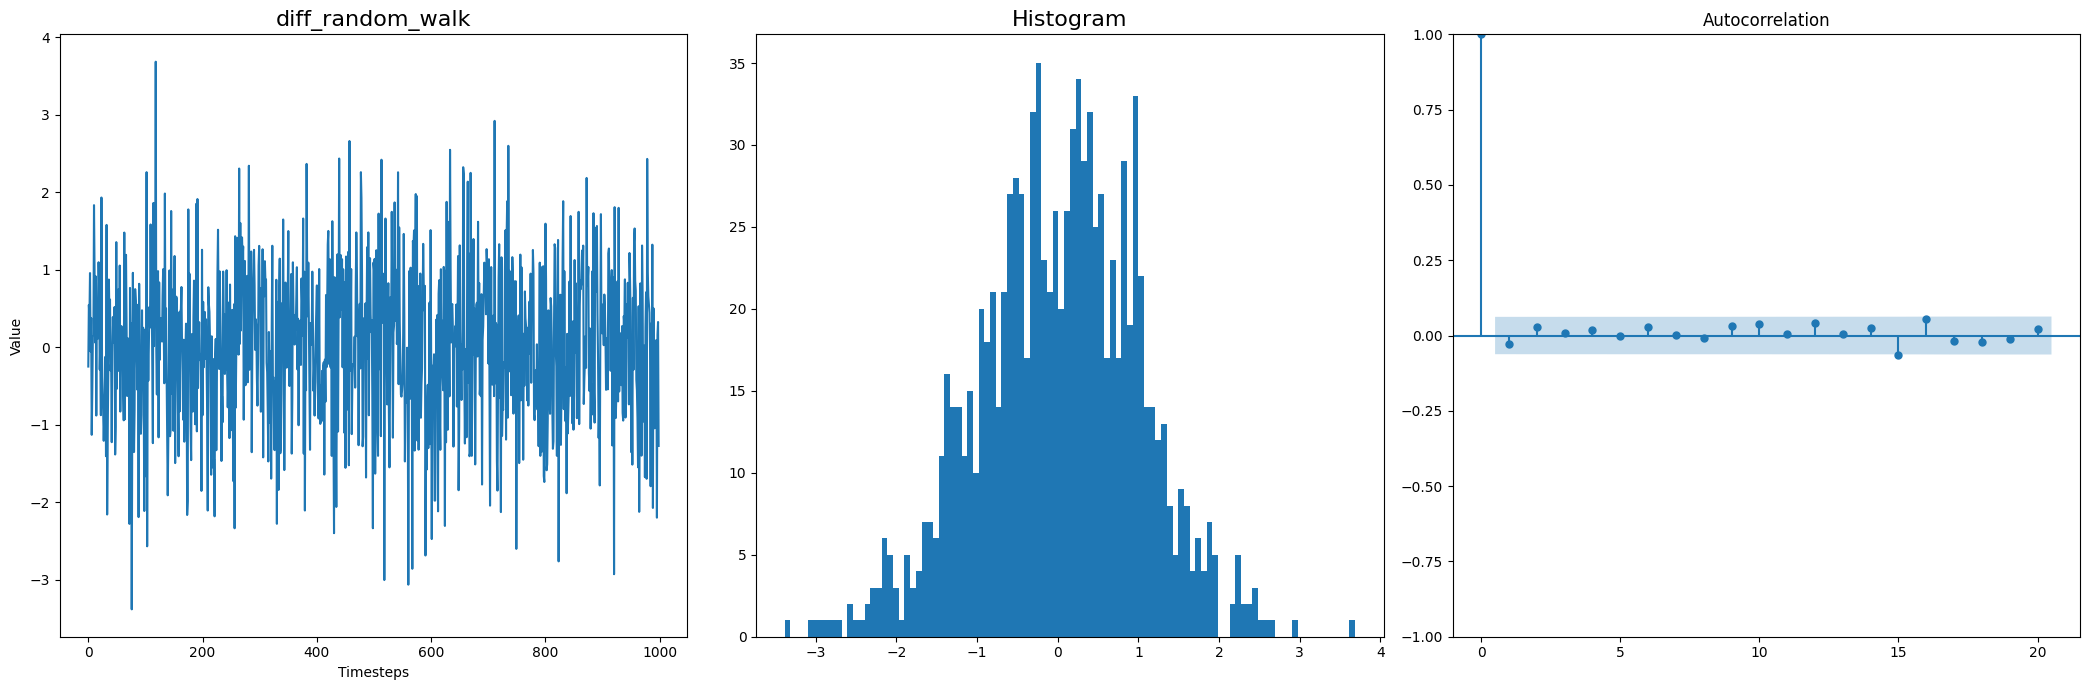

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7)) 

# Subplot 1: Random Walk
ax[0].plot(diff_random_walk) 
ax[0].set_xlabel('Timesteps')
ax[0].set_ylabel('Value')
ax[0].set_title('diff_random_walk', fontsize=16)

# Subplot 2: Histogram of Random Walk
ax[1].hist(diff_random_walk, bins=100)
ax[1].set_title('Histogram', fontsize=16)

# Subplot 3: Autocorrelation Plot
plot_acf(diff_random_walk, lags=20, ax=ax[2])

plt.tight_layout()
plt.show() 

Now, both the Auto Correlation Function and the Histogram (which is now Gaussian) indicate that the first-order difference is stationary.

### 3.2.5 Is GOOGL a random walk? 

In [58]:
GOOGL_ADF_result = adfuller(df['Close'])

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: 0.16025048664771374
p-value: 0.9699419435913057


    P-value > alpha ; H0: Not stationary

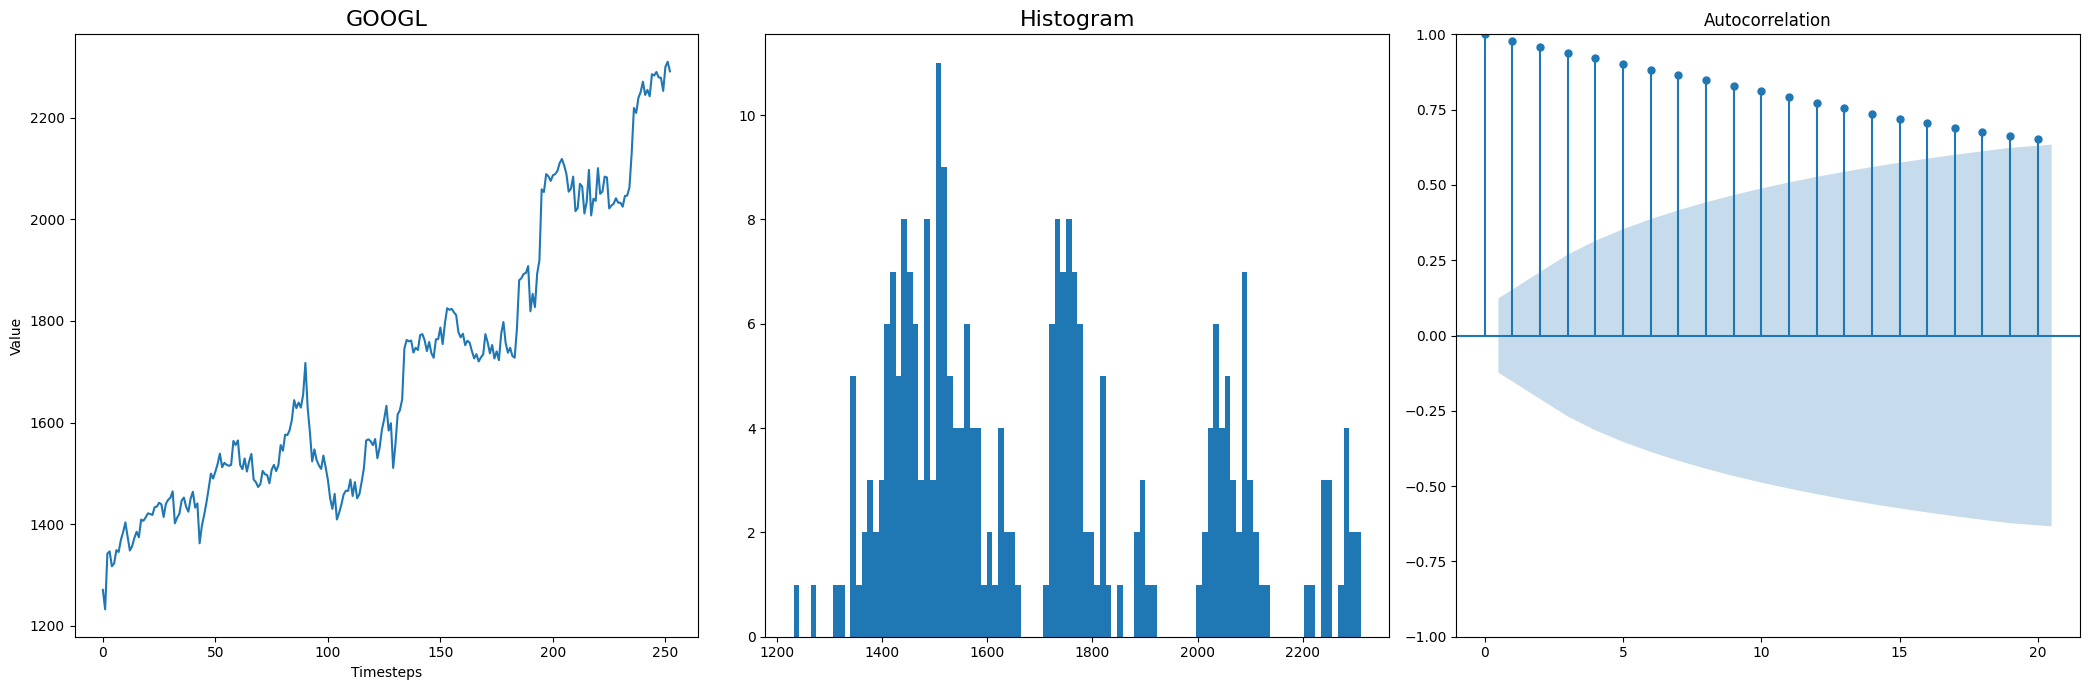

In [61]:
googl = df['Close']

fig, ax = plt.subplots(1, 3, figsize=(21, 7)) 

# Subplot 1: Random Walk
ax[0].plot(googl) 
ax[0].set_xlabel('Timesteps')
ax[0].set_ylabel('Value')
ax[0].set_title('GOOGL', fontsize=16)

# Subplot 2: Histogram of Random Walk
ax[1].hist(googl, bins=100)
ax[1].set_title('Histogram', fontsize=16)

# Subplot 3: Autocorrelation Plot
plot_acf(googl, lags=20, ax=ax[2])

plt.tight_layout()
plt.show() 

The histogram does not resemble a Gaussian distribution (it is not stationary), and the ACF indicates that each value is highly dependent on the previous value (it is not stationary).

In [64]:
# First-order differencing
diff_close = np.diff(df['Close'], n=1) 

In [66]:
GOOGL_diff_ADF_result = adfuller(diff_close)

print(f'ADF Statistic: {GOOGL_diff_ADF_result[0]}')
print(f'p-value: {GOOGL_diff_ADF_result[1]}')

ADF Statistic: -5.303439704295226
p-value: 5.386530961454778e-06


    P-value < alpha ; Ha: Stationary

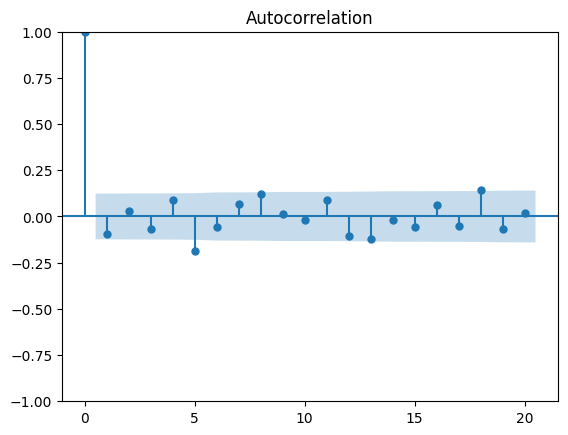

In [69]:
plot_acf(diff_close, lags=20);

*Stationary!*

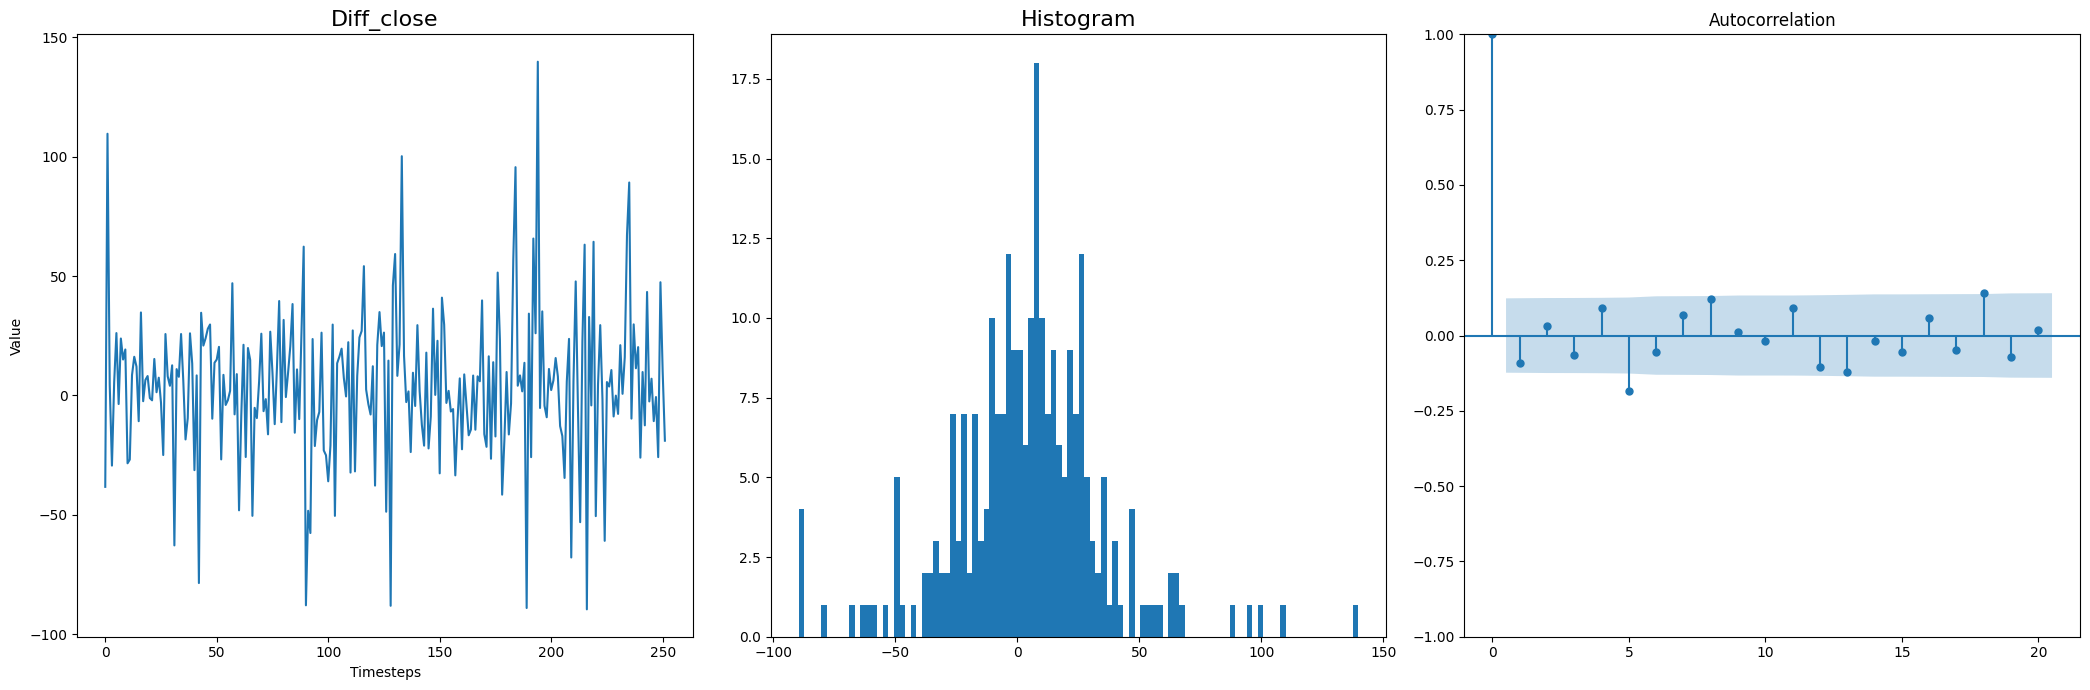

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7)) 

# Subplot 1: Random Walk
ax[0].plot(diff_close) 
ax[0].set_xlabel('Timesteps')
ax[0].set_ylabel('Value')
ax[0].set_title('Diff_close', fontsize=16)

# Subplot 2: Histogram of Random Walk
ax[1].hist(diff_close, bins=100)
ax[1].set_title('Histogram', fontsize=16)

# Subplot 3: Autocorrelation Plot
plot_acf(diff_close, lags=20, ax=ax[2])

plt.tight_layout()
plt.show() 

Now, both the Auto Correlation Function and the Histogram (which is now Gaussian) indicate that the first-order difference is stationary.

## 3.3 Forecasting a random walk
### 3.3.1 Forecasting on a long horizon

In [76]:
df = pd.DataFrame({'value': random_walk})

train = df[:800] # The first 80% of the data is assigned to the train set.
test = df[800:]  # Assign the last 20% of the data as test set

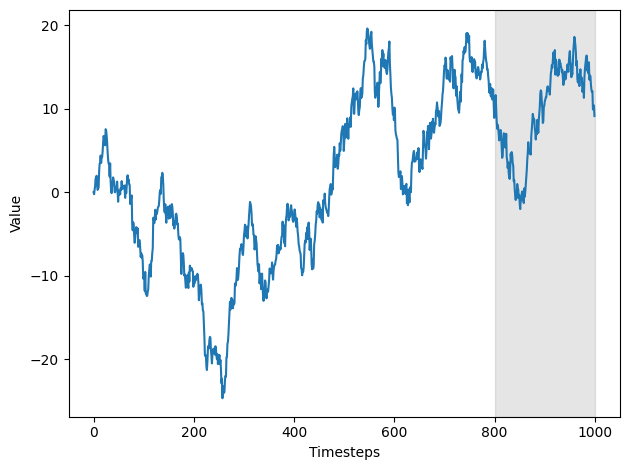

In [78]:
fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.tight_layout()

*The gray area is the region where the points are reserved to be the test set.*

In [81]:
mean = np.mean(train.value)       # Calculate the mean of the train set

test.loc[:, 'pred_mean'] = mean   # Predict the historical mean for the next 200 timesteps

test.head()                       # Show the first five rows of test

,value,pred_mean
800,9.140036,0.326504
801,10.734556,0.326504
802,11.611996,0.326504
803,10.022762,0.326504
804,8.511425,0.326504


In [83]:
last_value = train.iloc[-1].value       # Retrieve the last value of the train set

test.loc[:, 'pred_last'] = last_value   # Assign the last value as a prediction for the next 200 timesteps under the pred_last column

test.head()

,value,pred_mean,pred_last
800,9.140036,0.326504,8.887853
801,10.734556,0.326504,8.887853
802,11.611996,0.326504,8.887853
803,10.022762,0.326504,8.887853
804,8.511425,0.326504,8.887853


The drift method is a modification of predicting the last known value. In this case, we allow the
values to increase or decrease over time. The rate at which values will change in the
future is equal to that seen in the train set. Therefore, it is equivalent to calculating
the slope between the first and last value of the train set and simply extrapolating this
straight line into the future.

In [86]:
deltaX = 800 - 1                         # Calculate the difference in X (800 - 1)

deltaY = last_value - 0                  # Calculate the difference in Y (last_value - 0)

drift = deltaY / deltaX                  # Calculate the drift (slope) using deltaY and deltaX

x_vals = np.arange(801, 1001, 1)         # Generate an array of x values from 801 to 1000 (inclusive)

pred_drift = drift * x_vals              # Multiply the drift by each value in x_vals to get the predicted drift

test.loc[:, 'pred_drift'] = pred_drift   # Add the predicted drift values as a new column in the 'test' DataFrame


test.head()

,value,pred_mean,pred_last,pred_drift
800,9.140036,0.326504,8.887853,8.910100
801,10.734556,0.326504,8.887853,8.921224
802,11.611996,0.326504,8.887853,8.932348
803,10.022762,0.326504,8.887853,8.943471
804,8.511425,0.326504,8.887853,8.954595


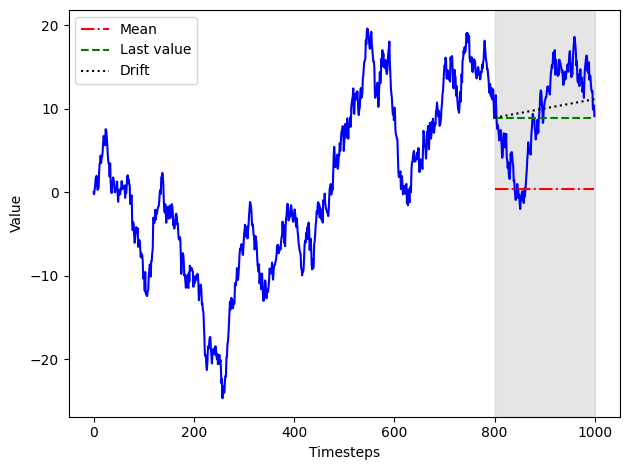

In [88]:
fig, ax = plt.subplots()                               # Create a new figure and axis for the plot

ax.plot(train.value, 'b-')                             # Plot the 'value' column from the 'train' DataFrame with a blue solid line
ax.plot(test['value'], 'b-')                           # Plot the 'value' column from the 'test' DataFrame with a blue solid line
ax.plot(test['pred_mean'], 'r-.', label='Mean')        # Plot the predicted mean with a red dash-dot line and label it as 'Mean'
ax.plot(test['pred_last'], 'g--', label='Last value')  # Plot the predicted last value with a green dashed line and label it as 'Last value'
ax.plot(test['pred_drift'], 'k:', label='Drift')       # Plot the predicted drift with a black dotted line and label it as 'Drift'

ax.axvspan(800, 1000, color='#808080', alpha=0.2)      # Highlight the region from x=800 to x=1000 with a gray shaded area

ax.legend(loc=2)                                       # Display the legend in the top-left corner

ax.set_xlabel('Timesteps')                             # Set the label for the x-axis
ax.set_ylabel('Value')                                 # Set the label for the y-axis

plt.tight_layout()                                     # Adjust the plot to ensure that all elements fit without overlap

In [90]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last'])
mse_drift = mean_squared_error(test['value'], test['pred_drift'])

print(mse_mean, mse_last, mse_drift)

115.26197154769844 30.46811202868662 25.339314478190627


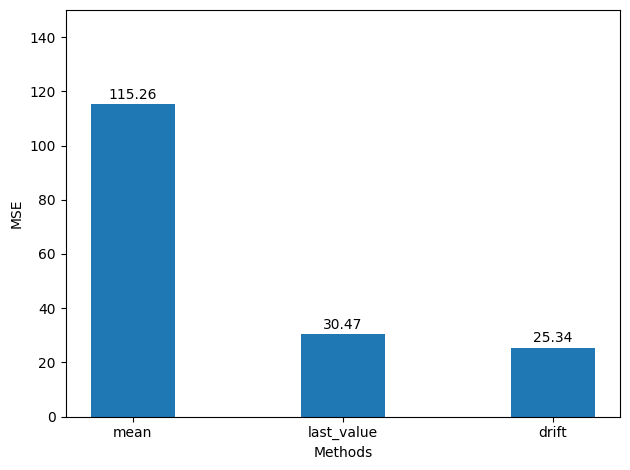

In [94]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'drift']
y = [mse_mean, mse_last, mse_drift]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 150)

for index, value in enumerate(y):
    plt.text(x=index, y=value+2, s=str(round(value, 2)), ha='center')

plt.tight_layout()

### 3.3.2 Forecasting the next timestep 

In [97]:
df.head()

,value
0,0.000000
1,-0.250397
2,0.295142
3,0.676911
4,1.633697


In [99]:
df_shift = df.shift(periods=1)

df_shift.head()

,value
0,NaN
1,0.000000
2,-0.250397
3,0.295142
4,0.676911


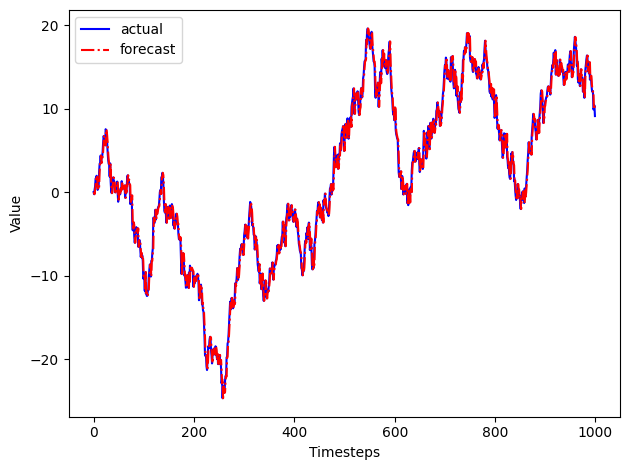

In [101]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

*A naive forecast of the next timestep of a random walk. This plot gives
the illusion of a very good model, when we are in fact only predicting the value
observed at the previous timestep.*

In [104]:
mse_one_step = mean_squared_error(test['value'], df_shift[800:])

mse_one_step

0.95480769449046

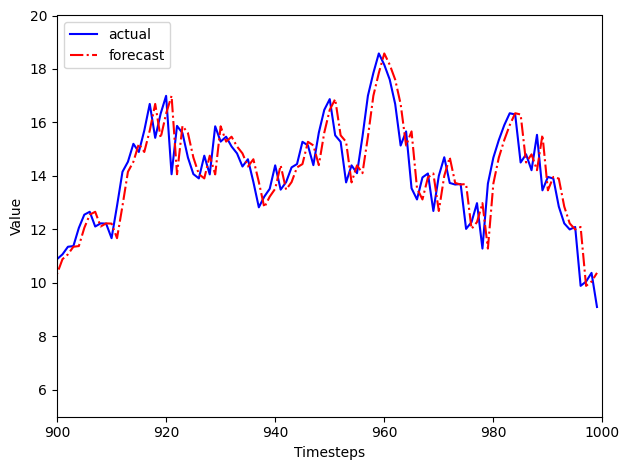

In [108]:
fig, ax = plt.subplots()

ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')

ax.legend(loc=2)

ax.set_xlim(900, 1000)
ax.set_ylim(5, 20)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()